In [1]:
import xarray as xr
import numpy as np
import dask as dask
from matplotlib import pyplot as plt
%matplotlib inline
import intake
import pandas as pd
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
import gsw

Sea water's Equation of State:
$$ \rho \simeq \rho_0 \left [ 1 - \frac{gz}{c_0^2} - \alpha_0(1 - \gamma_B z)(\Theta - \Theta_0)\frac{\gamma_C}{2}(\Theta - \Theta_0)^2 + \beta_0 (SA - S{A0} ) \right ] $$

In [2]:
#Gyre actually has the data file so instead of doing intake which takes a while when computing things, 
#you can just get it directly from Gyre using xarray zarr
ds_sose = xr.open_zarr('/swot/SUM03/tmp/SOSE')
ds_sose

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

In [15]:
ds_sose.SFLUX.units

'g/m^2/s'

In [16]:
ds_sose.TFLUX.units

'W/m^2'

In [3]:
sst = ds_sose.THETA.isel(Z=0)
sss = ds_sose.SALT.isel(Z=0)

Apply ufunc is doing several things for us:

1. Feeds the raw numpy arrays to the specified function (ufunc), in this case, `gsw.SA_from_SP`.
2. It broadcast the input arrays (`sss`, `0`, `XC`, and `YC`) into compatible shapes so numpy can operate on them together.
3. It automatically parallelizes the execution across all the chunks in a dask array
4. It wraps the output back in in xarray data array

In [4]:
#lazy mode
#converting practical salinity to absolute salinity
sa = xr.apply_ufunc(gsw.SA_from_SP, sss, 0, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [5]:
#converting potential temperature to conservative temperature
ct = xr.apply_ufunc(gsw.CT_from_pt, sa, sst,
                    output_dtypes=[sss.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

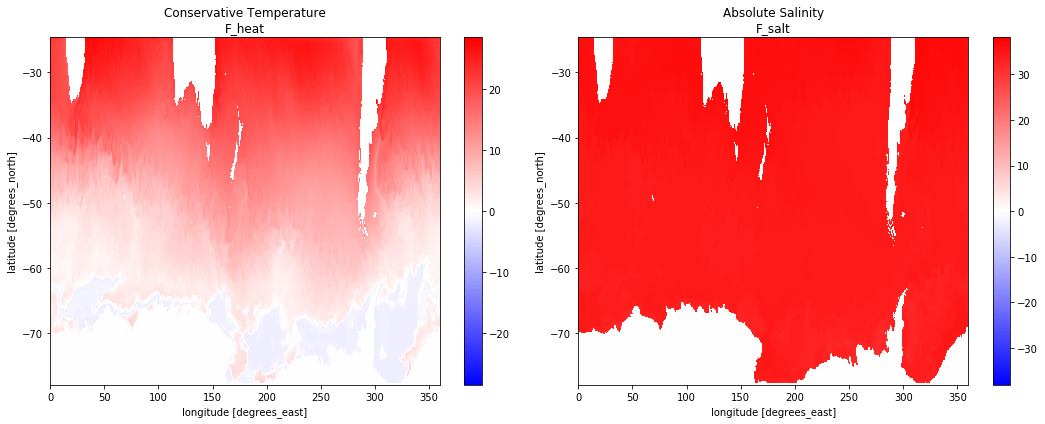

In [19]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ct[0].plot(ax=ax0, cmap='bwr')
ax0.set_title('Conservative Temperature\nF_heat')
sa[0].plot(ax=ax1, cmap='bwr')
ax1.set_title('Absolute Salinity\nF_salt')
plt.tight_layout();

### Compute density flux
$$
F_{\sigma} = F_{heat}\frac{\partial\sigma}{\partial\theta} + F_{salt}\frac{\partial\sigma}{\partial S}\
$$

$$
\alpha = - \frac{1}{\rho_{0}} \frac{\partial\rho}{\partial \theta}
$$
$$
\beta = \frac{1}{\rho_{0}} \frac{\partial\rho}{\partial S}
$$

In [20]:
runit2mass = 1.035e3 #rho_not

In [21]:
#thermal expansion coefficient
alpha = xr.apply_ufunc(gsw.alpha, sa, ct, 0,
                    output_dtypes=[sst.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [29]:
a0 = alpha[0].load()

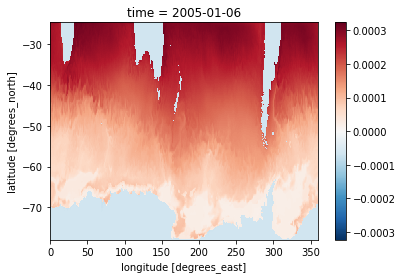

In [30]:
a0.plot()

In [ ]:
#haline contraction coefficient
beta = xr.apply_ufunc(gsw.beta, sa, ct, 0,
                      output_dtypes=[sss.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta

In [ ]:
rho = gsw.rho_alpha_beta(sa, ct, 0)
rho.load()

### Temperature component of F_sigma

In [35]:
heat_capacity_cp = 3.994e3
F_sig_heat = (rho * alpha * ds_sose.TFLUX) / (runit2mass * heat_capacity_cp)
F_sig_heat

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Text(0.5, 1.0, 'temperature component of\ndensity flux\nat t=0')

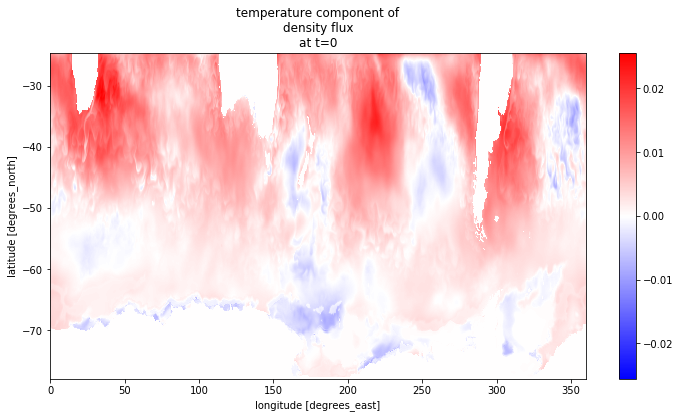

In [38]:
F_sig_heat[0].plot(figsize=(12,6), cmap='bwr')
plt.title('temperature component of\ndensity flux\nat t=0')

### Salinity component of F_sigma

In [32]:
F_sig_salt = runit2mass * beta * ds_sose.SFLUX
F_sig_salt

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

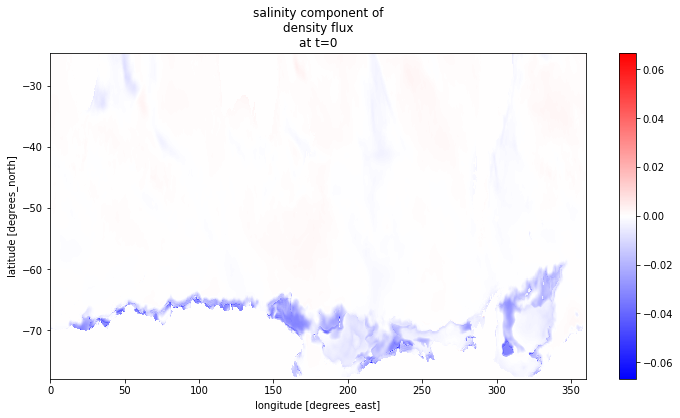

In [41]:
F_sig_salt[0].plot(figsize=(12,6), cmap='bwr')
plt.title('salinity component of\ndensity flux\nat t=0');

In [17]:
print(ds_sose.SFLUX, ds_sose.TFLUX)

<xarray.DataArray 'SFLUX' (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      total salt flux (match salt-content variations), >0 incre...
    standard_name:  SFLUX
    units:          g/m^2/s <xarray.DataArray 'TFLUX' (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * XC       (XC)

$$
F_{\sigma} = F_{heat}\frac{\partial\sigma}{\partial\theta} + F_{salt}\frac{\partial\sigma}{\partial S}\
$$

$$
where
$$

$$
F_{heat} = \frac{\partial \theta}{\partial t}\ is\ the\ heat\ flux
$$

$$
F_{salt} = \frac{\partial \theta}{\partial t}\ is\ the\ salt\ flux
$$

$$
where\ \frac{\partial\sigma}{\partial\theta} \sim \alpha = -\frac{1}{\rho_0}\frac{\partial\rho}{\partial\theta}\ is\ the\ thermal\ expansion\ coefficient
$$

$$
where\ \frac{\partial\sigma}{\partial S} \sim \beta = \frac{1}{\rho_0}\frac{\partial\rho}{\partial S}\ is\ the\ haline\ contraction\ coefficient 
$$

In [19]:
beta

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [20]:
#multiply by another rho because of definition of rho
F_sigma = (ds_sose.TFLUX / (runit2mass*heat_capacity_cp))*alpha + (ds_sose.SFLUX / runit2mass)*beta
F_sigma

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [21]:
F_sigma['time']

<xarray.DataArray 'time' (time: 438)>
array(['2005-01-06T00:00:00.000000000', '2005-01-11T00:00:00.000000000',
       '2005-01-16T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [22]:
F_sigma.time

<xarray.DataArray 'time' (time: 438)>
array(['2005-01-06T00:00:00.000000000', '2005-01-11T00:00:00.000000000',
       '2005-01-16T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [23]:
ds_sose.TFLUX

<xarray.DataArray 'TFLUX' (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      total heat flux (match heat-content variations), >0 incre...
    standard_name:  TFLUX
    units:          W/m^2

In [24]:
group_time = F_sigma.groupby('time.month').mean(dim='time')
group_time

<xarray.DataArray (month: 12, YC: 320, XC: 2160)>
dask.array<shape=(12, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [25]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ann_mean = group_time.mean(dim='month')
    ann_mean.load()

[#                                       ] | 3% Completed |  5.2s

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)


[####################                    ] | 51% Completed | 43.1s

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 22.4s


Text(0.5, 1.0, 'density flux\nunits: kg/m^2/s')

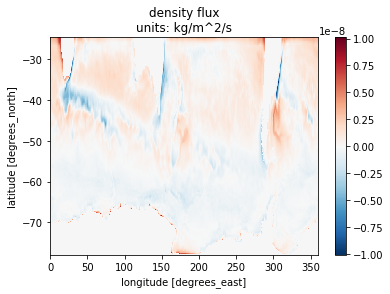

In [26]:
ann_mean.plot()
plt.title('density flux\nunits: kg/m^2/s')

1. So from here try to first convert this density flux map to buoyancy flux by multiplying it by g/rho
2. then convert m^2 to mm^2
3. See if this matches Ferrari's figure 3 and then if it does change pressure to 3 other reference pressures then see how they change!

In [27]:
#to go from density flux to buoyancy flux multiply by (-g/rho)
ferrari = ann_mean*(-9.81/1035)*10e6
ferrari

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.000291, -0.000291, -0.00029 , ..., -0.000289, -0.00029 , -0.000291],
       [-0.0003  , -0.000299, -0.000299, ..., -0.000296, -0.000297, -0.000299],
       [-0.000304, -0.000304, -0.000304, ..., -0.000301, -0.000302, -0.000304]],
      dtype=float32)
Coordinates:
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

In [ ]:
#still off by a factor of 100 - maybe that comes from the g to kg conversion for SFLUX term in F_sigma?
#colors seem inverted
(100*ferrari).sel(YC=slice(-80,-40)).plot(figsize=(15,7), cmap='bwr', vmin=-0.02, vmax=0.02)
#plt.pcolormesh(edgecolors='white')
plt.title('Ferrari Fig.3 of Annual Mean Buoyancy Flux\nP=0');

# Past Efforts below for trying what is achieved above
Best not to delete these so that you can look back on your though process and see the progression

In [ ]:
#For ECCO Model
cat = intake.Catalog('https://raw.githubusercontent.com/pangeo-data/pangeo_ocean_examples/master/catalog.yaml')
ds_ecco = cat.ECCOv4r3.to_dask()
#ds_ecco

In [ ]:
#For SOSE Model
cat = intake.Catalog('https://raw.githubusercontent.com/pangeo-data/pangeo_ocean_examples/master/catalog.yaml')
ds = cat.SOSE.to_dask()
ds

In [ ]:
#to make things more efficient only pull the variables you want to work with
vars_i_want = ['SFLUX', 'TFLUX', 'SALT', 'THETA']
my_ds = ds[vars_i_want].isel(Z=0)
my_ds

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    my_ds.load()

In [ ]:
my_ds.nbytes/1e9

In [ ]:
ds.XG

In [ ]:
for vname in ds.data_vars:
    print(vname, ds[vname].attrs["long_name"], ds[vname].attrs["units"])

In [ ]:
ds.PHrefC

In [ ]:
ds.SFLUX

In [ ]:
ds.SALT

$$
\frac{D\sigma}{Dt} = \dot{\sigma_{\theta}} = \frac{\partial\sigma_{\theta}}{\partial\theta}\dot{\theta} + \frac{\partial\sigma_{\theta}}{\partial S}\dot{S}
$$

$$
where\ \dot{\theta} = \frac{D\theta}{Dt} = G^{\theta}_{hdiff} + G^{\theta}_{vdiff} + G^{\theta}_{KPP} + G^{\theta}_{surf} + G^{\theta}_{sw}
$$

$$
where\ \dot{S} = \frac{DS}{Dt} = G^{S}_{hdiff} + G^{S}_{vdiff} + G^{S}_{KPP} + G^{S}_{surf}
$$

$$
where\ \frac{\partial\sigma}{\partial\theta} = 
$$

$$
where\ \frac{\partial\sigma}{\partial S} = 
$$

$$
Isopycnal\ Slope:
s \simeq \frac{\tau}{\rho_{0}fK}
$$
Ferrari et al. (2014) **PNAS**

In [ ]:
tau = 0.1 #N/m^2
rho_0 = 1027 #kg/m^3
f = 2*7.2921e-5*np.sin(-65)
K = 1000 #m^2/s Eddy diffusivity

In [ ]:
taux = ds.oceTAUX
taux

In [ ]:
taux.sel(YC=-65, method='nearest').plot();

In [ ]:
taux_65S = taux.sel(YC=-65, method='nearest')
taux_65S.mean(dim='XG').plot()
plt.title('Zonally averaged taux at -65˚S');

In [ ]:
taux.mean(dim=('XG', 'time')).plot()

In [ ]:
strata = taux.mean(dim=('XG', 'time'))
strata

In [ ]:
ds.PHrefF.plot()

In [ ]:
ds.ADVy_SLT

In [ ]:
ds.ADVy_TH

In [ ]:
plt.figure(figsize=(10,10))
extent = [-180, 180, -80, -55]
central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_lon))
ax.coastlines(resolution='50m')
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

In [ ]:
plt.figure(figsize=(10,10))
extent = [-180, 180, -80, -55]
#central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines(resolution='50m')
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')